In [1]:
# from google.colab import drive

# # This will prompt you to click a link and get an authorization code
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install tsfresh
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.3 MB/s eta 0:00:00


In [3]:

import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.signal import find_peaks
import numpy as np
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_error


from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters

os.chdir("/content/gdrive/MyDrive/DMP")
pd.set_option("display.precision", 2)

In [4]:

import pandas as pd

people = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17']
columns_needed = ["Time[s]", "Delta_Time","MET", "Activity"]

def time_lagged_features(data, time_lags):
    for time_lag in time_lags:
        data['Activity_lag_b_{}'.format(time_lag)] = data['Activity'].shift(time_lag)
        data['Activity_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)

        # Now create the forward lagged features
        data['Activity_lag_f_{}'.format(time_lag)] = data['Activity'].shift(-time_lag)
        data['Activity_lag_f_{}'.format(time_lag)].fillna(method='ffill', inplace=True)
    return data

time_lagged_features_enabled = True

data = []
for person in people:
    df = pd.read_pickle("merged_dataset/{0}/ALL.pkl".format(person))
    df_subset = df[columns_needed]
    df_subset.ffill(inplace=True)
    df_subset.bfill(inplace=True)

    if time_lagged_features_enabled:
        time_lags = [x for x in range(1, 15, 2)]
        df_subset = time_lagged_features(df_subset, time_lags)

    coulms_feature_eng = ["Activity", "Time[s]"]
    features = extract_features(df_subset[coulms_feature_eng], column_id='Time[s]',
                                 default_fc_parameters=MinimalFCParameters(),
                                 n_jobs=4)

    # Merge features back into the original DataFrame
    df_subset = df_subset.merge(features, left_on='Time[s]', right_index=True)

    df_subset['Person'] = person
    data.append(df_subset)


print(data[0])


<ipython-input-4-0db9feef08a6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.ffill(inplace=True)
<ipython-input-4-0db9feef08a6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.bfill(inplace=True)
<ipython-input-4-0db9feef08a6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Activity_lag_b_{}'.format(time_lag)] = data['Activity'].shift(time_lag)
<i

                     Time[s]      Delta_Time   MET  Activity  \
Time                                                           
2021-12-03 16:58:51      1.0 0 days 00:00:00  1.31       1.0   
2021-12-03 16:58:52      2.0 0 days 00:00:01  1.31       1.0   
2021-12-03 16:58:53      3.0 0 days 00:00:02  1.52       1.0   
2021-12-03 16:58:54      4.0 0 days 00:00:03  1.63       1.0   
2021-12-03 16:58:55      5.0 0 days 00:00:04  1.56       1.0   
...                      ...             ...   ...       ...   
2021-12-03 17:28:48   1798.0 0 days 00:29:57  5.32       5.0   
2021-12-03 17:28:49   1799.0 0 days 00:29:58  5.11       5.0   
2021-12-03 17:28:50   1800.0 0 days 00:29:59  4.46       5.0   
2021-12-03 17:28:51   1801.0 0 days 00:30:00  4.12       5.0   
2021-12-03 17:28:52   1802.0 0 days 00:30:01  4.43       5.0   

                     Activity_lag_b_1  Activity_lag_f_1  Activity_lag_b_3  \
Time                                                                        
2021-12-03 16

In [5]:
data[0]

Time[s]      Delta_Time   MET  Activity  \
Time                                                           
2021-12-03 16:58:51      1.0 0 days 00:00:00  1.31       1.0   
2021-12-03 16:58:52      2.0 0 days 00:00:01  1.31       1.0   
2021-12-03 16:58:53      3.0 0 days 00:00:02  1.52       1.0   
2021-12-03 16:58:54      4.0 0 days 00:00:03  1.63       1.0   
2021-12-03 16:58:55      5.0 0 days 00:00:04  1.56       1.0   
...                      ...             ...   ...       ...   
2021-12-03 17:28:48   1798.0 0 days 00:29:57  5.32       5.0   
2021-12-03 17:28:49   1799.0 0 days 00:29:58  5.11       5.0   
2021-12-03 17:28:50   1800.0 0 days 00:29:59  4.46       5.0   
2021-12-03 17:28:51   1801.0 0 days 00:30:00  4.12       5.0   
2021-12-03 17:28:52   1802.0 0 days 00:30:01  4.43       5.0   

                     Activity_lag_b_1  Activity_lag_f_1  Activity_lag_b_3  \
Time                                                                        
2021-12-03 16:58:51               1.0               1.0               1.0   
2021-12-03 16:58:52               1.0               1.0               1.0   
2021-12-03 16:58:53               1.0               1.0               1.0   
2021-12-03 16:58:54               1.0               1.0               1.0   
2021-12-03 16:58:55               1.0               1.0               1.0   
...                               ...               ...               ...   
2021-12-03 17:28:48               5.0               5.0               5.0   
2021-12-03 17:28:49               5.0               5.0               5.0   
2021-12-03 17:28:50               5.0               5.0               5.0   
2021-12-03 17:28:51               5.0               5.0               5.0   
2021-12-03 17:28:52               5.0               5.0               5.0   

                     Activity_lag_f_3  Activity_lag_b_5  Activity_lag_f_5  \
Time                                                                        
2021-12-03 16:58:51               1.0               1.0               1.0   
2021-12-03 16:58:52               1.0               1.0               1.0   
2021-12-03 16:58:53               1.0               1.0               1.0   
2021-12-03 16:58:54               1.0               1.0               1.0   
2021-12-03 16:58:55               1.0               1.0               1.0   
...                               ...               ...               ...   
2021-12-03 17:28:48               5.0               5.0               5.0   
2021-12-03 17:28:49               5.0               5.0               5.0   
2021-12-03 17:28:50               5.0               5.0               5.0   
2021-12-03 17:28:51               5.0               5.0               5.0   
2021-12-03 17:28:52               5.0               5.0               5.0   

                     ...  Activity__median  Activity__mean  Activity__length  \
Time                 ...                                                       
2021-12-03 16:58:51  ...               1.0             1.0               1.0   
2021-12-03 16:58:52  ...               1.0             1.0               1.0   
2021-12-03 16:58:53  ...               1.0             1.0               1.0   
2021-12-03 16:58:54  ...               1.0             1.0               1.0   
2021-12-03 16:58:55  ...               1.0             1.0               1.0   
...                  ...               ...             ...               ...   
2021-12-03 17:28:48  ...               5.0             5.0               1.0   
2021-12-03 17:28:49  ...               5.0             5.0               1.0   
2021-12-03 17:28:50  ...               5.0             5.0               1.0   
2021-12-03 17:28:51  ...               5.0             5.0               1.0   
2021-12-03 17:28:52  ...               5.0             5.0               1.0   

                     Activity__standard_deviation  Activity__variance  \
Time                                                                  

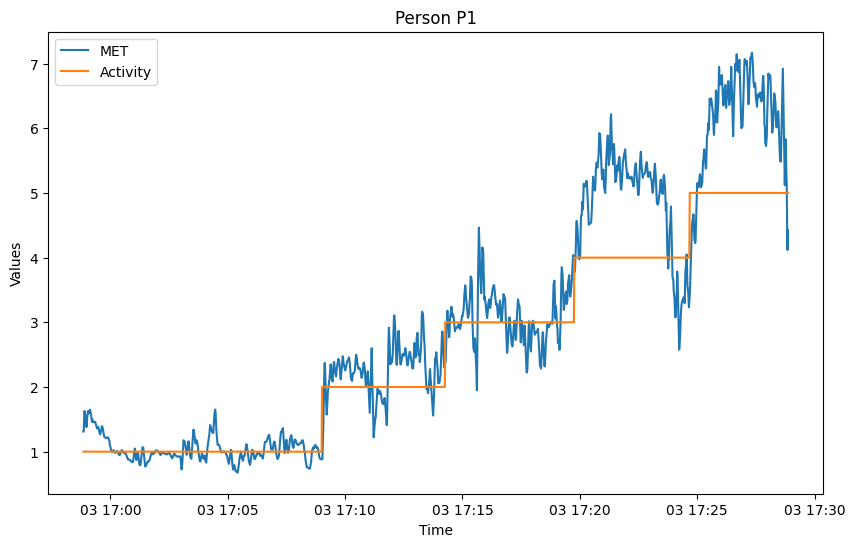

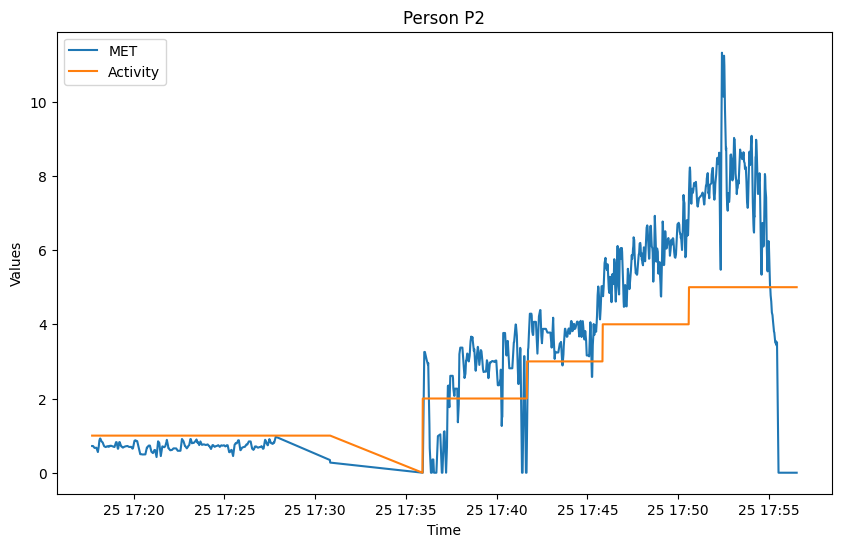

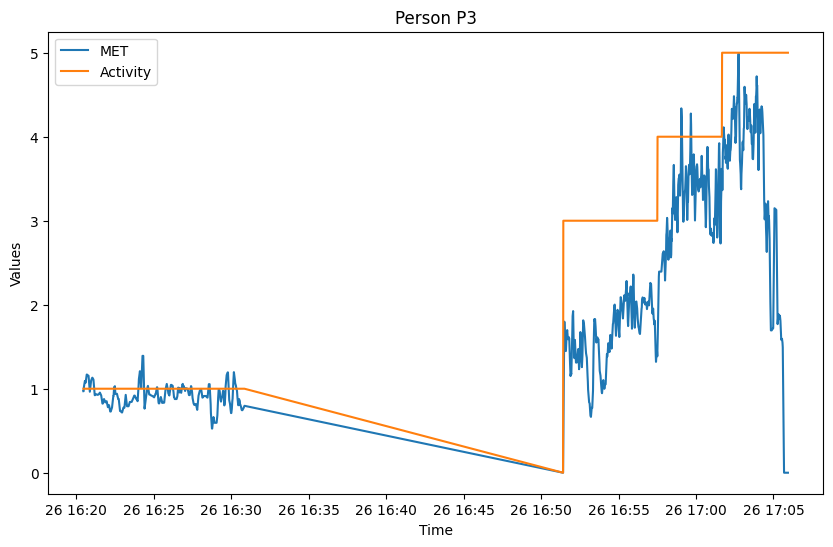

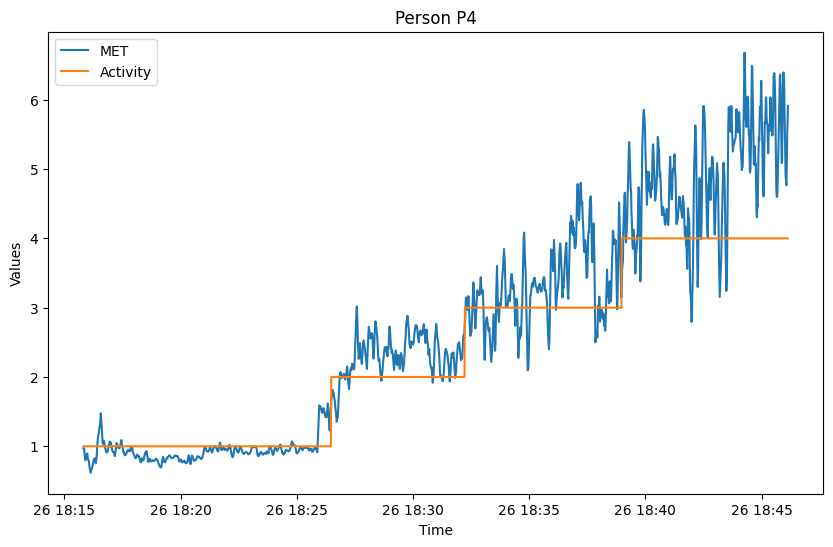

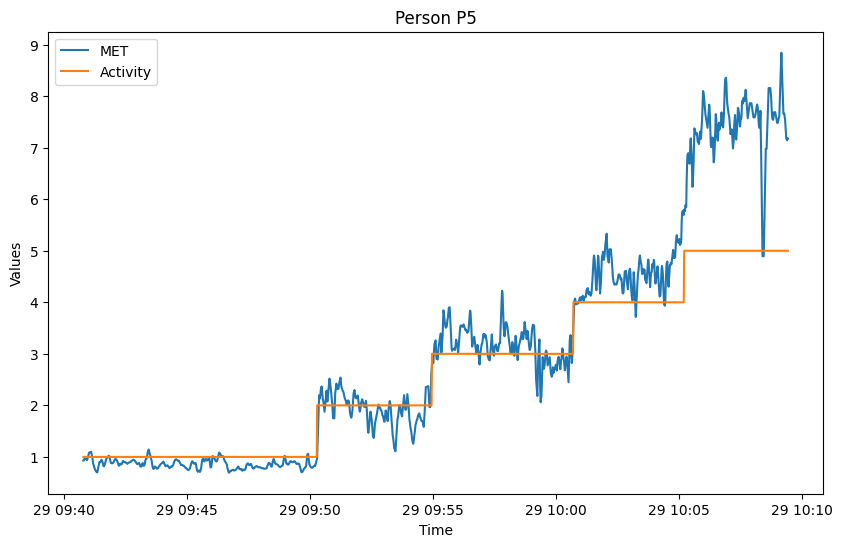

In [6]:
import matplotlib.pyplot as plt

# Iterate over the data list
for i, df_subset in enumerate(data):
  if i < 5:
    person = people[i]

    # Extract MET and value__bpm columns
    MET = df_subset['MET']
    value_bpm = df_subset['Activity'].ffill()

    # Plot MET and value__bpm
    plt.figure(figsize=(10, 6))
    plt.plot(MET, label='MET')
    plt.plot(value_bpm, label='Activity')
    plt.title(f'Person {person}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


## Model training

### Train/test splitting

In [7]:
concatenated_data = pd.concat(data, axis=0)
data_new = concatenated_data.copy()

X_data = data_new.drop(columns=["Delta_Time", "MET", "Time[s]", "Person"]).copy()
print(X_data.columns)
X_data = X_data.to_numpy()

Y_data = concatenated_data['MET']
Y_data = Y_data.to_numpy()
people = concatenated_data['Person']

Index(['Activity', 'Activity_lag_b_1', 'Activity_lag_f_1', 'Activity_lag_b_3',
       'Activity_lag_f_3', 'Activity_lag_b_5', 'Activity_lag_f_5',
       'Activity_lag_b_7', 'Activity_lag_f_7', 'Activity_lag_b_9',
       'Activity_lag_f_9', 'Activity_lag_b_11', 'Activity_lag_f_11',
       'Activity_lag_b_13', 'Activity_lag_f_13', 'Activity__sum_values',
       'Activity__median', 'Activity__mean', 'Activity__length',
       'Activity__standard_deviation', 'Activity__variance',
       'Activity__root_mean_square', 'Activity__maximum',
       'Activity__absolute_maximum', 'Activity__minimum'],
      dtype='object')


In [8]:
# concatenated_data = pd.concat(data, axis=0)

# concatenated_data = concatenated_data.dropna()

# X_data = concatenated_data[columns_needed].copy()
# X_data = X_data.to_numpy()

# Y_data = concatenated_data['MET']
# Y_data = Y_data.to_numpy()
# people = concatenated_data['Person']

In [9]:
normalizer = MinMaxScaler()
X_data = normalizer.fit_transform(X_data)

### XGBoost with cross validation

#### Cross validation

In [10]:
group_kfold = GroupKFold(n_splits=17)
cv = [split for split in group_kfold.split(X_data, Y_data, people)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)

In [11]:
for i,group in enumerate(cv):
    print(f"Fold {i}")
    print(f"Train size: {group[0].size}")
    print(f"Test size: {group[1].size}")
    print(f"Train participants: {people.iloc[group[0]].unique()}")
    print(f"Test participants: {people.iloc[group[1]].unique()}")

Fold 0
Train size: 25854
Test size: 1802
Train participants: ['P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P1']
Fold 1
Train size: 25630
Test size: 2026
Train participants: ['P1' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P2']
Fold 2
Train size: 26159
Test size: 1497
Train participants: ['P1' 'P2' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P3']
Fold 3
Train size: 25836
Test size: 1820
Train participants: ['P1' 'P2' 'P3' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P4']
Fold 4
Train size: 25937
Test size: 1719
Train participants: ['P1' 'P2' 'P3' 'P4' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P5']
Fold 5
Train size: 26006
Test size: 1650
Train participants: ['P1' 'P2' 'P3' 'P4' 'P5' 'P7' 'P8' 'P9' 'P10' 'P

In [12]:

parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create XGBRegressor model
model = XGBRegressor(colsample_bytree=0.56, subsample=0.3, min_child_weight=0.6)

# Define GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=17)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search with custom CV splitter
grid_search = GridSearchCV(model, parameters_grid, cv=group_kfold.split(X_data, Y_data, people), scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


Best parameters found:
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
Best mean absolute error found: 0.7525631146339721


P1


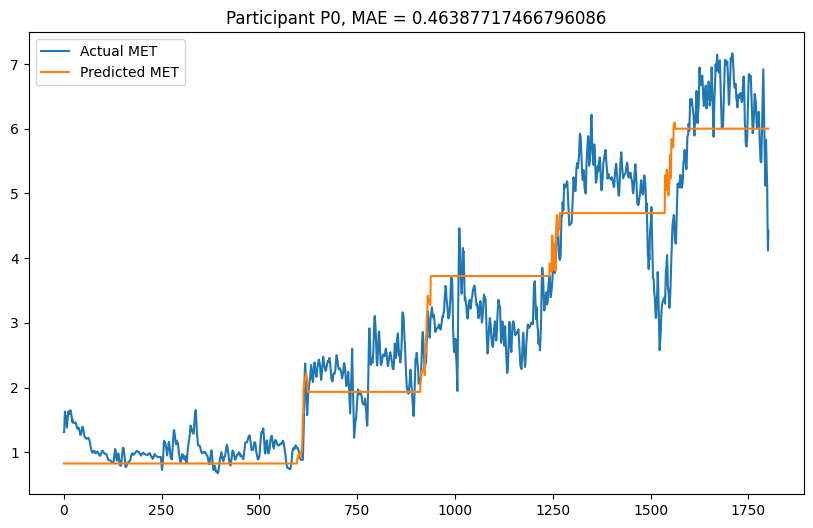

P1


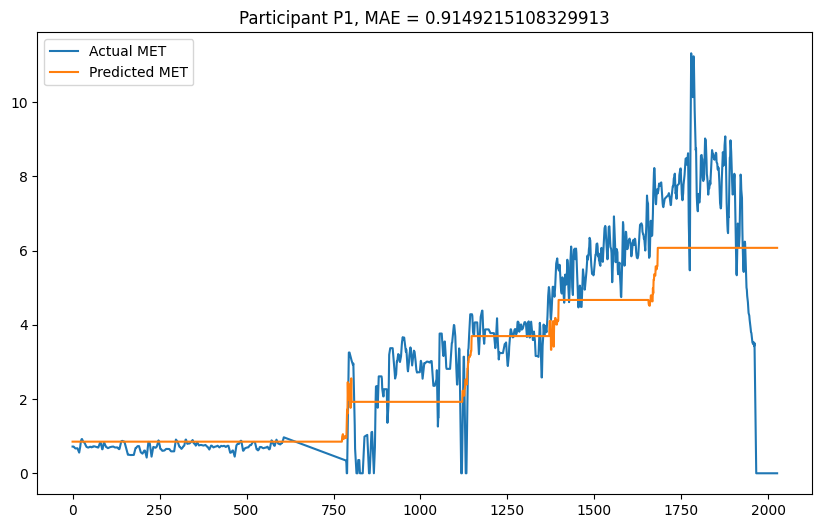

P1


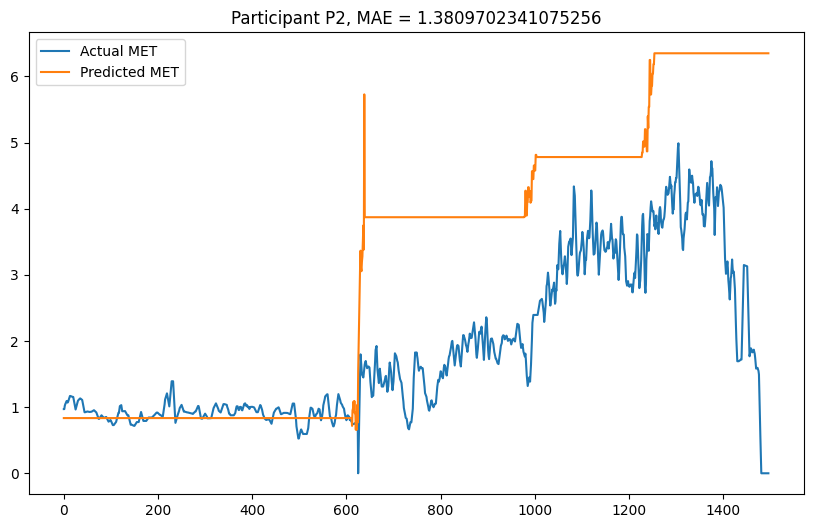

P1


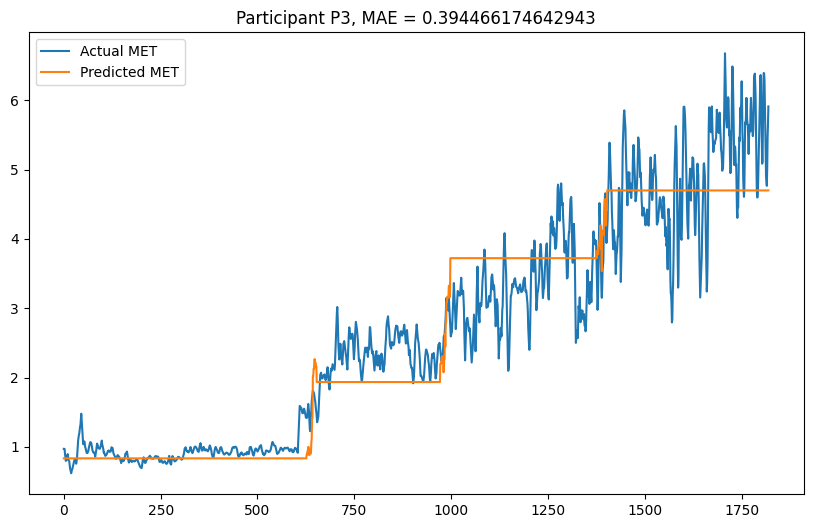

P1


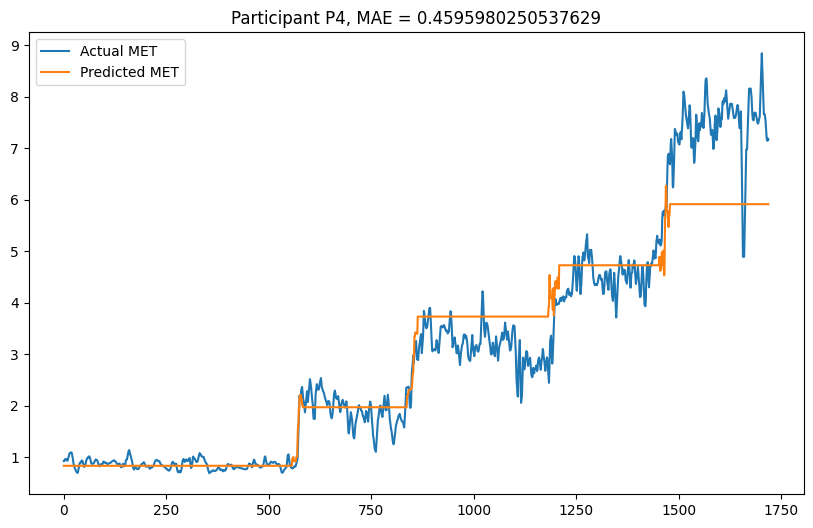

P1


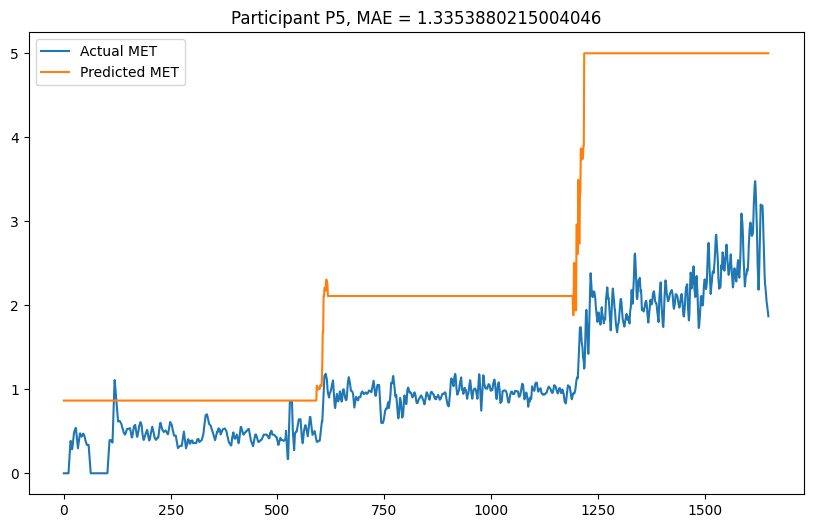

P1


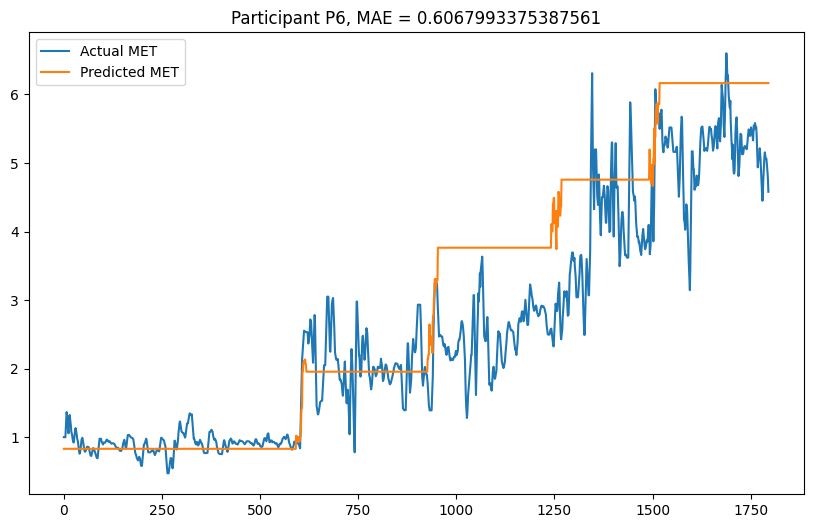

P1


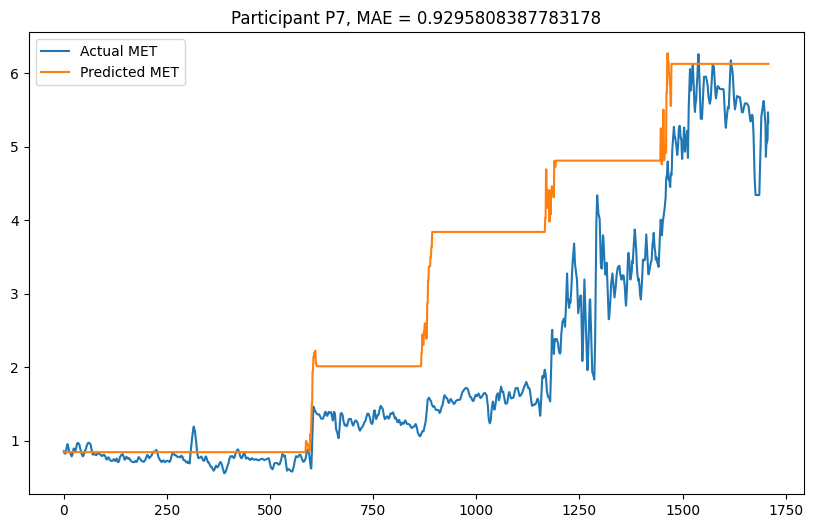

P1


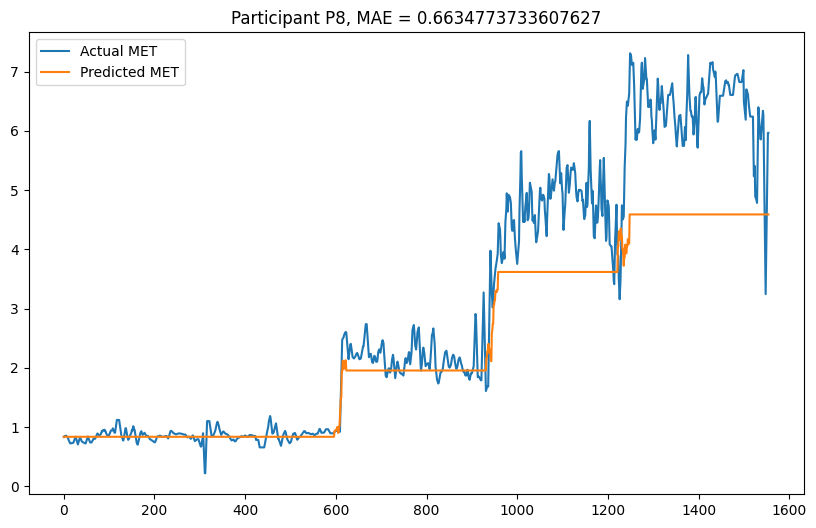

P1


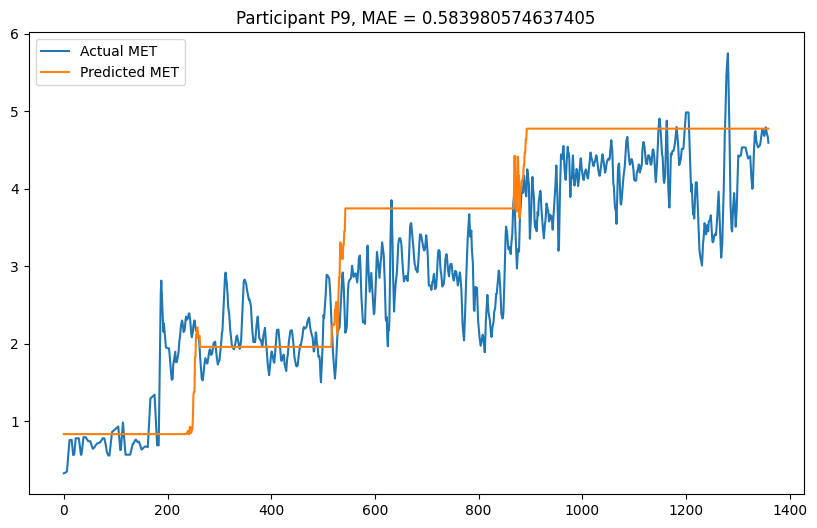

P1


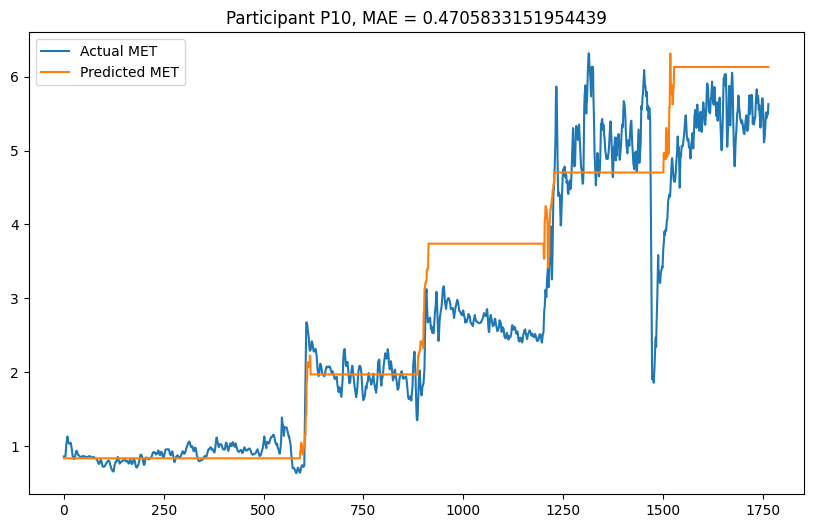

P1


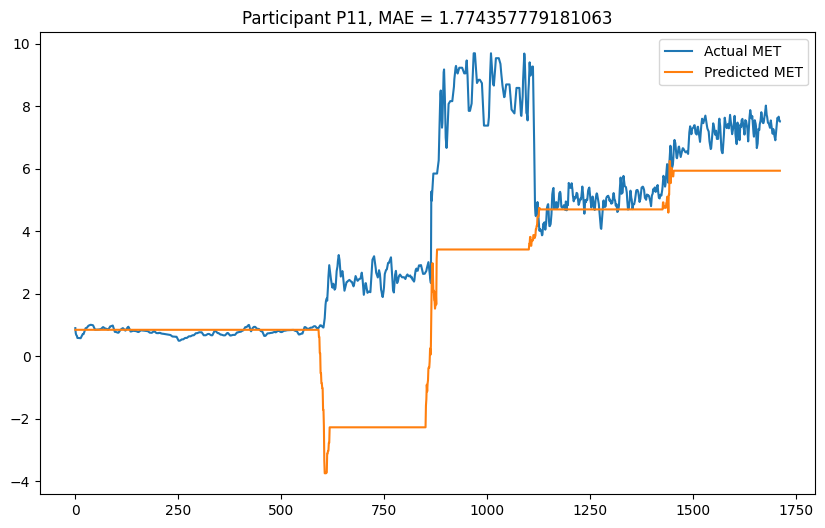

P1


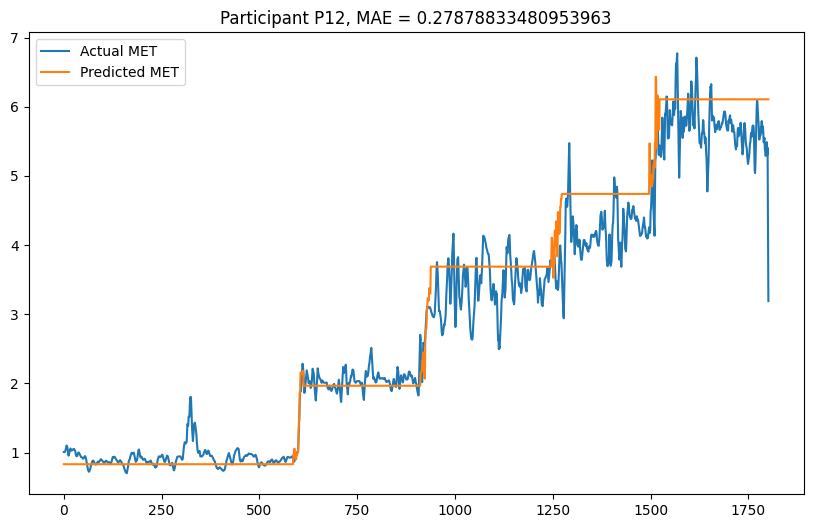

P1


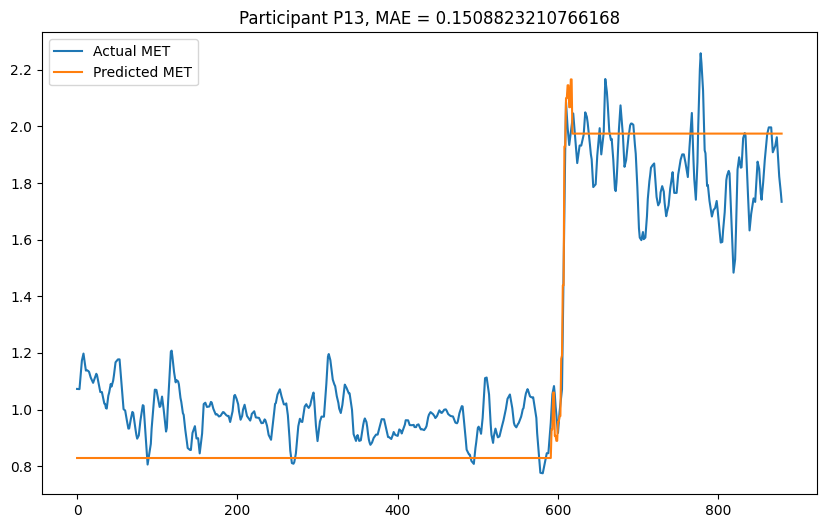

P1


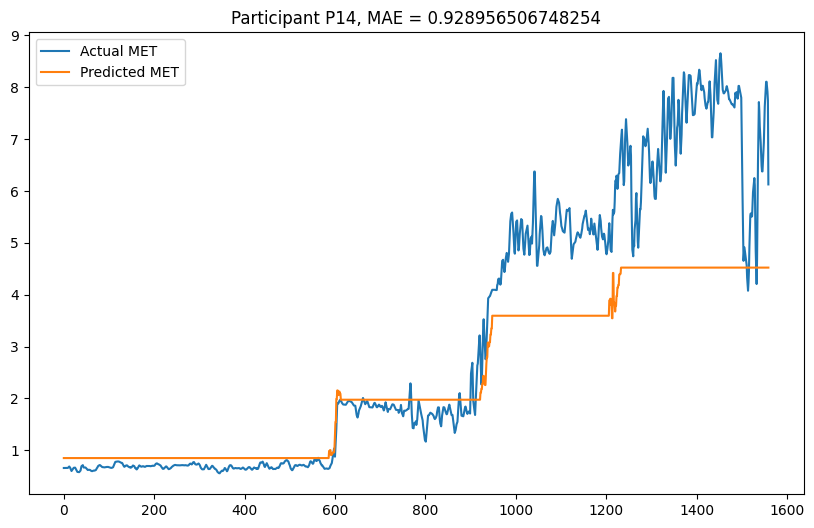

P1


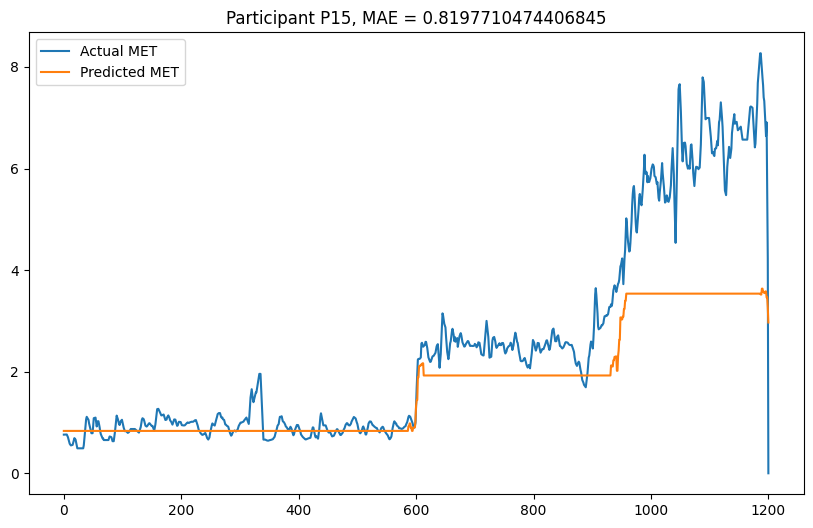

P1


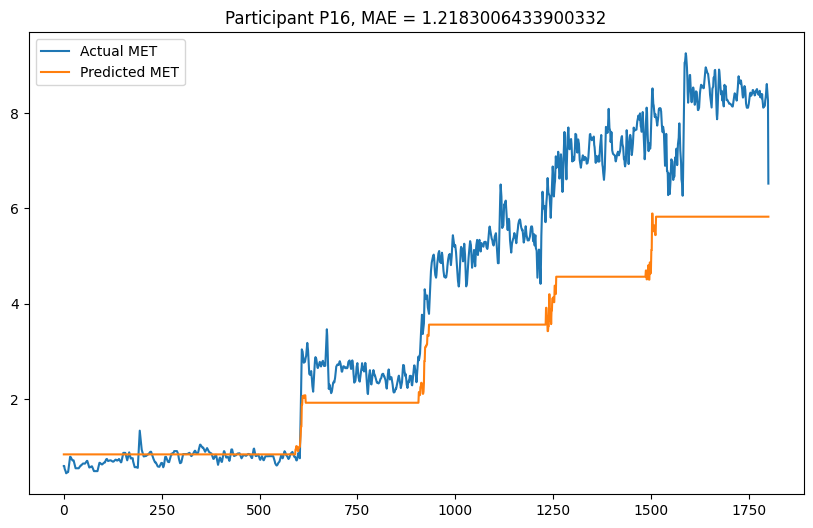

In [13]:
# print(cv)
mae_list_xgboost =[]
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    print(people[fold])

    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]

    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    mae = mean_absolute_error(Y_test, Y_pred)
    mae_list_xgboost.append((fold + 1,mae))

    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant P{}, MAE = {}'.format(fold, mae))
    plt.legend()
    plt.show()


In [14]:

# Define the parameters grid
parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create CatBoostRegressor model
model = CatBoostRegressor()

# Define GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=17)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search
grid_search = GridSearchCV(model, parameters_grid, cv=group_kfold.split(X_data, Y_data, people), scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


0:	learn: 2.1402743	total: 51.9ms	remaining: 25.9s
1:	learn: 2.1264383	total: 56.6ms	remaining: 14.1s
2:	learn: 2.1126027	total: 60.3ms	remaining: 9.98s
3:	learn: 2.0990190	total: 63.8ms	remaining: 7.92s
4:	learn: 2.0855292	total: 67.2ms	remaining: 6.66s
5:	learn: 2.0722212	total: 70.5ms	remaining: 5.81s
6:	learn: 2.0590955	total: 73.9ms	remaining: 5.2s
7:	learn: 2.0461752	total: 77.2ms	remaining: 4.75s
8:	learn: 2.0334056	total: 80.6ms	remaining: 4.39s
9:	learn: 2.0208678	total: 83.9ms	remaining: 4.11s
10:	learn: 2.0084387	total: 87.1ms	remaining: 3.87s
11:	learn: 1.9962284	total: 90.5ms	remaining: 3.68s
12:	learn: 1.9841609	total: 94.2ms	remaining: 3.53s
13:	learn: 1.9723037	total: 97.5ms	remaining: 3.38s
14:	learn: 1.9605686	total: 101ms	remaining: 3.26s
15:	learn: 1.9490575	total: 104ms	remaining: 3.15s
16:	learn: 1.9376170	total: 107ms	remaining: 3.05s
17:	learn: 1.9263214	total: 111ms	remaining: 2.97s
18:	learn: 1.9151859	total: 114ms	remaining: 2.9s
19:	learn: 1.9042731	total: 1

P1
Learning rate set to 0.068448
0:	learn: 2.0677917	total: 8.24ms	remaining: 8.23s
1:	learn: 1.9732309	total: 14.3ms	remaining: 7.15s
2:	learn: 1.8881565	total: 20ms	remaining: 6.66s
3:	learn: 1.8111913	total: 25.7ms	remaining: 6.39s
4:	learn: 1.7406494	total: 31.6ms	remaining: 6.28s
5:	learn: 1.6768579	total: 36.9ms	remaining: 6.12s
6:	learn: 1.6193767	total: 42.1ms	remaining: 5.97s
7:	learn: 1.5678668	total: 47.3ms	remaining: 5.86s
8:	learn: 1.5216975	total: 52.8ms	remaining: 5.81s
9:	learn: 1.4803891	total: 58.3ms	remaining: 5.77s
10:	learn: 1.4437063	total: 63.5ms	remaining: 5.71s
11:	learn: 1.4110096	total: 68.9ms	remaining: 5.67s
12:	learn: 1.3819928	total: 74.8ms	remaining: 5.68s
13:	learn: 1.3562917	total: 80.8ms	remaining: 5.69s
14:	learn: 1.3335291	total: 86.1ms	remaining: 5.65s
15:	learn: 1.3132924	total: 91.6ms	remaining: 5.63s
16:	learn: 1.2953831	total: 97.5ms	remaining: 5.64s
17:	learn: 1.2797330	total: 104ms	remaining: 5.67s
18:	learn: 1.2659117	total: 109ms	remaining:

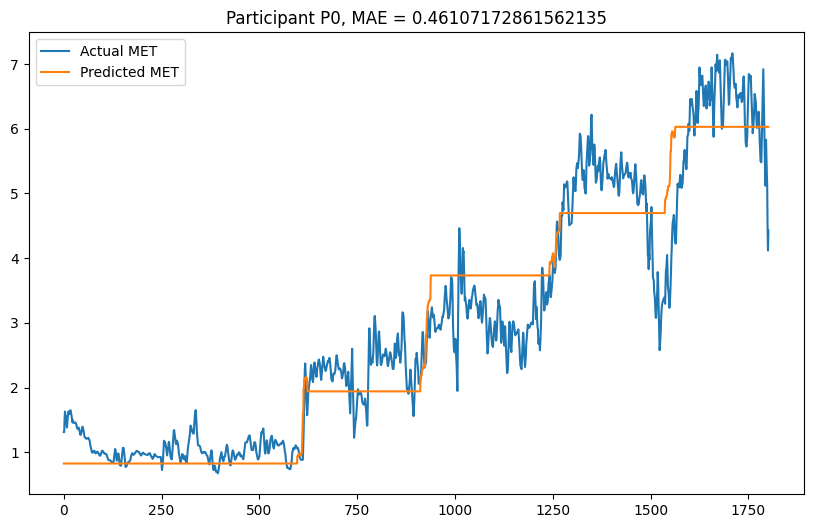

P1
Learning rate set to 0.068354
0:	learn: 2.0052153	total: 7.95ms	remaining: 7.95s
1:	learn: 1.9115515	total: 13.4ms	remaining: 6.67s
2:	learn: 1.8271399	total: 19.3ms	remaining: 6.42s
3:	learn: 1.7507198	total: 25.2ms	remaining: 6.28s
4:	learn: 1.6807411	total: 31.2ms	remaining: 6.22s
5:	learn: 1.6171883	total: 36.6ms	remaining: 6.05s
6:	learn: 1.5599123	total: 41.5ms	remaining: 5.89s
7:	learn: 1.5082109	total: 46.5ms	remaining: 5.77s
8:	learn: 1.4621235	total: 51.4ms	remaining: 5.66s
9:	learn: 1.4207784	total: 56.4ms	remaining: 5.58s
10:	learn: 1.3840178	total: 61.3ms	remaining: 5.51s
11:	learn: 1.3516897	total: 66.4ms	remaining: 5.46s
12:	learn: 1.3226131	total: 71.4ms	remaining: 5.42s
13:	learn: 1.2967301	total: 76.8ms	remaining: 5.41s
14:	learn: 1.2737412	total: 81.9ms	remaining: 5.38s
15:	learn: 1.2533462	total: 87.5ms	remaining: 5.38s
16:	learn: 1.2351416	total: 93ms	remaining: 5.38s
17:	learn: 1.2192595	total: 98.6ms	remaining: 5.38s
18:	learn: 1.2052294	total: 104ms	remaining

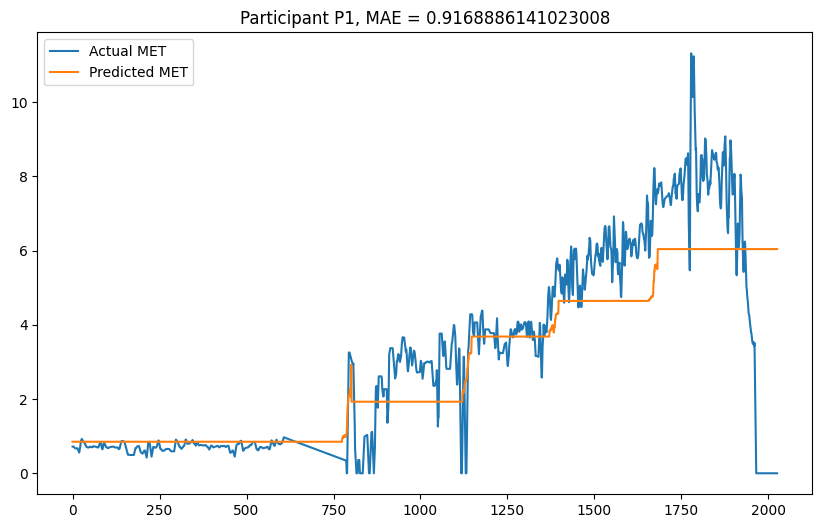

P1
Learning rate set to 0.068575
0:	learn: 2.0768970	total: 7.21ms	remaining: 7.21s
1:	learn: 1.9752809	total: 12.8ms	remaining: 6.38s
2:	learn: 1.8834108	total: 19.1ms	remaining: 6.35s
3:	learn: 1.8001274	total: 25ms	remaining: 6.22s
4:	learn: 1.7236033	total: 30.7ms	remaining: 6.1s
5:	learn: 1.6541749	total: 36.4ms	remaining: 6.04s
6:	learn: 1.5914527	total: 42ms	remaining: 5.95s
7:	learn: 1.5347688	total: 47.4ms	remaining: 5.88s
8:	learn: 1.4840134	total: 52.8ms	remaining: 5.81s
9:	learn: 1.4384557	total: 58.2ms	remaining: 5.77s
10:	learn: 1.3978500	total: 64.1ms	remaining: 5.76s
11:	learn: 1.3619858	total: 69.8ms	remaining: 5.75s
12:	learn: 1.3296875	total: 75.5ms	remaining: 5.73s
13:	learn: 1.3009363	total: 81.1ms	remaining: 5.71s
14:	learn: 1.2754120	total: 86.6ms	remaining: 5.68s
15:	learn: 1.2526612	total: 92.4ms	remaining: 5.68s
16:	learn: 1.2324606	total: 98.3ms	remaining: 5.68s
17:	learn: 1.2147695	total: 104ms	remaining: 5.68s
18:	learn: 1.1991301	total: 110ms	remaining: 5.

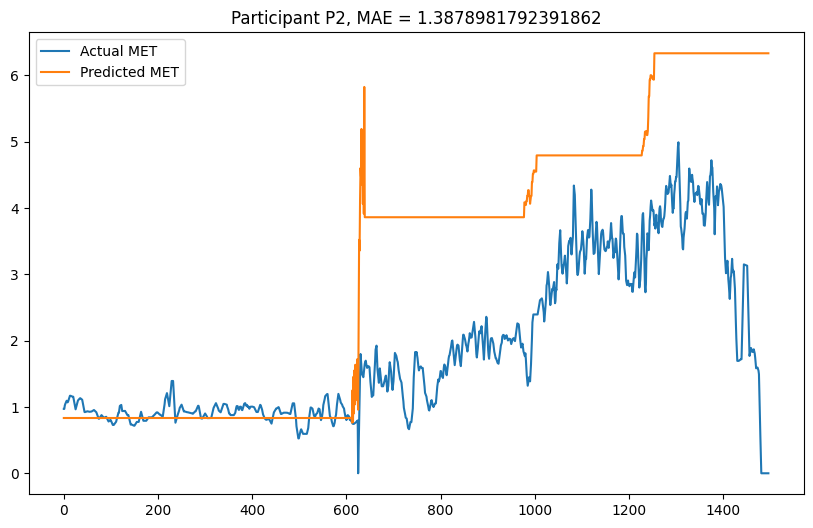

P1
Learning rate set to 0.06844
0:	learn: 2.0839030	total: 6.97ms	remaining: 6.96s
1:	learn: 1.9880188	total: 12ms	remaining: 6s
2:	learn: 1.9016580	total: 17.8ms	remaining: 5.91s
3:	learn: 1.8235771	total: 23.5ms	remaining: 5.85s
4:	learn: 1.7521463	total: 28.7ms	remaining: 5.71s
5:	learn: 1.6873749	total: 34.5ms	remaining: 5.72s
6:	learn: 1.6290284	total: 39.9ms	remaining: 5.66s
7:	learn: 1.5766694	total: 45.2ms	remaining: 5.6s
8:	learn: 1.5298023	total: 50.4ms	remaining: 5.55s
9:	learn: 1.4878522	total: 55.5ms	remaining: 5.5s
10:	learn: 1.4503825	total: 60.8ms	remaining: 5.47s
11:	learn: 1.4175399	total: 66.5ms	remaining: 5.47s
12:	learn: 1.3880857	total: 72ms	remaining: 5.47s
13:	learn: 1.3619037	total: 77.6ms	remaining: 5.47s
14:	learn: 1.3386123	total: 82.9ms	remaining: 5.44s
15:	learn: 1.3180084	total: 89.4ms	remaining: 5.5s
16:	learn: 1.2997159	total: 95ms	remaining: 5.5s
17:	learn: 1.2837549	total: 101ms	remaining: 5.49s
18:	learn: 1.2695851	total: 106ms	remaining: 5.45s
19:	l

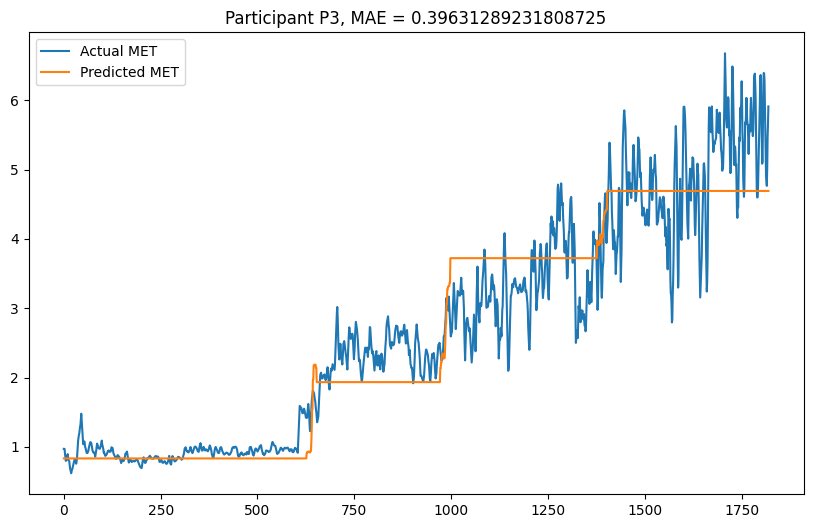

P1
Learning rate set to 0.068482
0:	learn: 2.0453986	total: 6.54ms	remaining: 6.54s
1:	learn: 1.9524131	total: 11.9ms	remaining: 5.91s
2:	learn: 1.8688213	total: 17.6ms	remaining: 5.86s
3:	learn: 1.7931791	total: 23.3ms	remaining: 5.81s
4:	learn: 1.7238456	total: 28.4ms	remaining: 5.66s
5:	learn: 1.6611669	total: 33.6ms	remaining: 5.56s
6:	learn: 1.6047461	total: 38.7ms	remaining: 5.49s
7:	learn: 1.5541594	total: 44.1ms	remaining: 5.47s
8:	learn: 1.5089120	total: 49.3ms	remaining: 5.42s
9:	learn: 1.4684730	total: 54.7ms	remaining: 5.41s
10:	learn: 1.4323233	total: 60.8ms	remaining: 5.47s
11:	learn: 1.4006851	total: 66.1ms	remaining: 5.45s
12:	learn: 1.3723038	total: 71.6ms	remaining: 5.43s
13:	learn: 1.3471019	total: 76.7ms	remaining: 5.4s
14:	learn: 1.3246387	total: 81.7ms	remaining: 5.37s
15:	learn: 1.3046821	total: 87.7ms	remaining: 5.39s
16:	learn: 1.2871103	total: 93.8ms	remaining: 5.42s
17:	learn: 1.2718114	total: 100ms	remaining: 5.47s
18:	learn: 1.2581976	total: 107ms	remaining

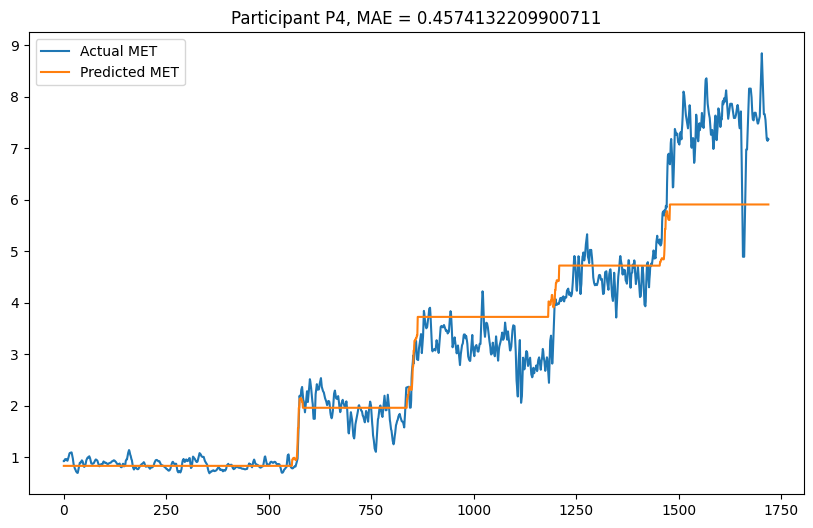

P1
Learning rate set to 0.068511
0:	learn: 2.0652135	total: 17.7ms	remaining: 17.6s
1:	learn: 1.9661702	total: 26.3ms	remaining: 13.1s
2:	learn: 1.8766916	total: 47.4ms	remaining: 15.7s
3:	learn: 1.7955379	total: 72.7ms	remaining: 18.1s
4:	learn: 1.7210697	total: 89.6ms	remaining: 17.8s
5:	learn: 1.6537494	total: 102ms	remaining: 16.9s
6:	learn: 1.5929785	total: 113ms	remaining: 16s
7:	learn: 1.5381350	total: 127ms	remaining: 15.7s
8:	learn: 1.4890788	total: 152ms	remaining: 16.8s
9:	learn: 1.4452050	total: 175ms	remaining: 17.4s
10:	learn: 1.4059811	total: 190ms	remaining: 17.1s
11:	learn: 1.3714069	total: 205ms	remaining: 16.8s
12:	learn: 1.3402627	total: 219ms	remaining: 16.6s
13:	learn: 1.3125071	total: 235ms	remaining: 16.6s
14:	learn: 1.2877140	total: 250ms	remaining: 16.4s
15:	learn: 1.2659968	total: 267ms	remaining: 16.4s
16:	learn: 1.2465741	total: 284ms	remaining: 16.4s
17:	learn: 1.2296603	total: 300ms	remaining: 16.4s
18:	learn: 1.2146768	total: 325ms	remaining: 16.8s
19:	l

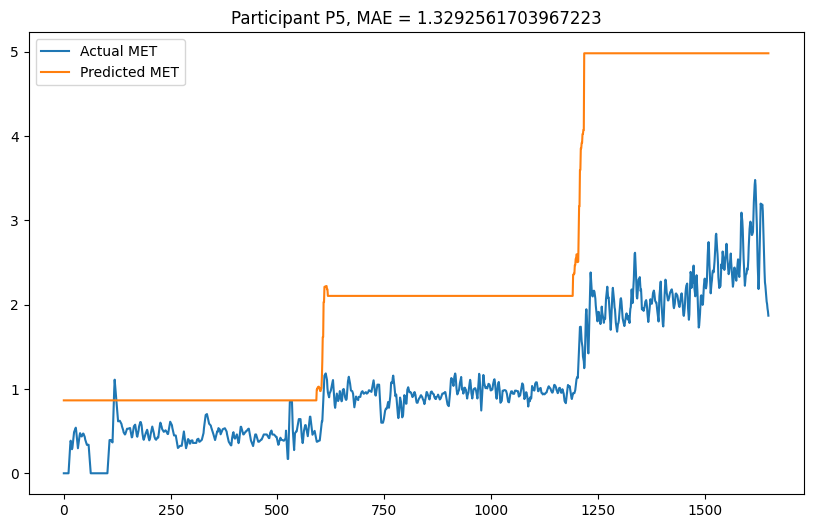

P1
Learning rate set to 0.06845
0:	learn: 2.0819459	total: 6.71ms	remaining: 6.71s
1:	learn: 1.9853549	total: 12.4ms	remaining: 6.2s
2:	learn: 1.8978815	total: 18ms	remaining: 5.98s
3:	learn: 1.8190637	total: 24ms	remaining: 5.99s
4:	learn: 1.7470656	total: 35.5ms	remaining: 7.06s
5:	learn: 1.6817180	total: 48.9ms	remaining: 8.11s
6:	learn: 1.6228692	total: 55.7ms	remaining: 7.9s
7:	learn: 1.5700069	total: 61.9ms	remaining: 7.68s
8:	learn: 1.5226903	total: 67ms	remaining: 7.38s
9:	learn: 1.4803511	total: 72.2ms	remaining: 7.15s
10:	learn: 1.4424678	total: 77.4ms	remaining: 6.96s
11:	learn: 1.4092857	total: 82.7ms	remaining: 6.81s
12:	learn: 1.3794098	total: 88.2ms	remaining: 6.7s
13:	learn: 1.3529358	total: 93.6ms	remaining: 6.59s
14:	learn: 1.3294637	total: 99ms	remaining: 6.5s
15:	learn: 1.3086054	total: 104ms	remaining: 6.42s
16:	learn: 1.2900725	total: 110ms	remaining: 6.36s
17:	learn: 1.2739222	total: 116ms	remaining: 6.33s
18:	learn: 1.2596303	total: 121ms	remaining: 6.27s
19:	le

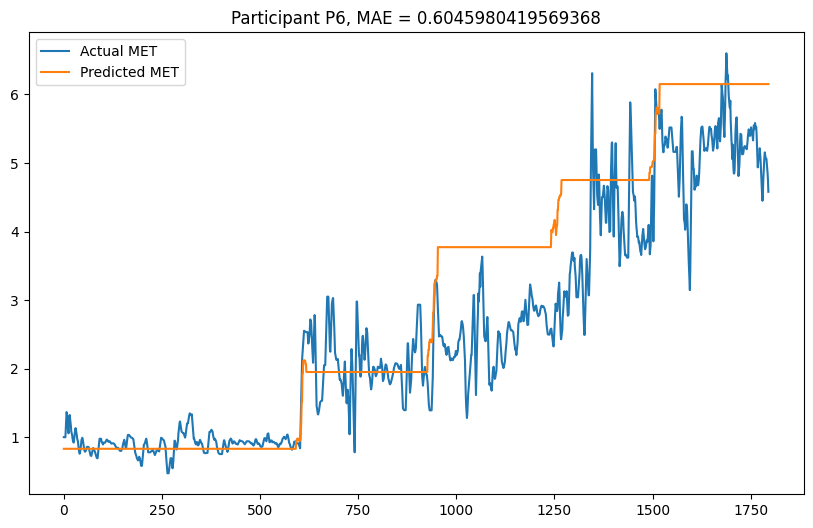

P1
Learning rate set to 0.068487
0:	learn: 2.0713096	total: 6.57ms	remaining: 6.57s
1:	learn: 1.9737130	total: 11.9ms	remaining: 5.93s
2:	learn: 1.8852911	total: 17.4ms	remaining: 5.79s
3:	learn: 1.8055301	total: 23.5ms	remaining: 5.86s
4:	learn: 1.7324819	total: 28.7ms	remaining: 5.71s
5:	learn: 1.6663209	total: 33.8ms	remaining: 5.6s
6:	learn: 1.6066524	total: 38.9ms	remaining: 5.52s
7:	learn: 1.5530464	total: 49.2ms	remaining: 6.11s
8:	learn: 1.5054966	total: 58.1ms	remaining: 6.4s
9:	learn: 1.4624459	total: 63.3ms	remaining: 6.27s
10:	learn: 1.4238850	total: 68.7ms	remaining: 6.17s
11:	learn: 1.3901171	total: 74.2ms	remaining: 6.11s
12:	learn: 1.3597511	total: 79.5ms	remaining: 6.03s
13:	learn: 1.3327229	total: 84.9ms	remaining: 5.98s
14:	learn: 1.3086779	total: 90.2ms	remaining: 5.92s
15:	learn: 1.2873798	total: 96.2ms	remaining: 5.91s
16:	learn: 1.2684721	total: 102ms	remaining: 5.9s
17:	learn: 1.2519501	total: 115ms	remaining: 6.26s
18:	learn: 1.2372682	total: 125ms	remaining: 6

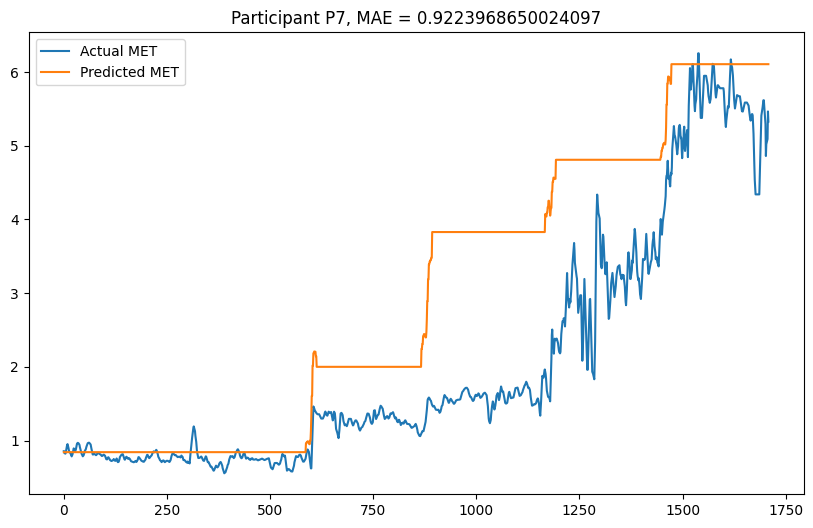

P1
Learning rate set to 0.068551
0:	learn: 2.0465510	total: 7.16ms	remaining: 7.16s
1:	learn: 1.9521595	total: 12.3ms	remaining: 6.15s
2:	learn: 1.8672862	total: 18.2ms	remaining: 6.05s
3:	learn: 1.7903992	total: 24.8ms	remaining: 6.18s
4:	learn: 1.7200657	total: 30.4ms	remaining: 6.04s
5:	learn: 1.6563182	total: 35.6ms	remaining: 5.9s
6:	learn: 1.5988992	total: 41ms	remaining: 5.82s
7:	learn: 1.5472419	total: 46.2ms	remaining: 5.73s
8:	learn: 1.5011149	total: 51.5ms	remaining: 5.67s
9:	learn: 1.4598257	total: 57.2ms	remaining: 5.67s
10:	learn: 1.4230231	total: 62.5ms	remaining: 5.62s
11:	learn: 1.3907898	total: 68.1ms	remaining: 5.61s
12:	learn: 1.3618242	total: 73.1ms	remaining: 5.55s
13:	learn: 1.3360843	total: 78.4ms	remaining: 5.52s
14:	learn: 1.3132640	total: 87.8ms	remaining: 5.76s
15:	learn: 1.2930599	total: 95.5ms	remaining: 5.87s
16:	learn: 1.2750759	total: 104ms	remaining: 6.04s
17:	learn: 1.2594232	total: 110ms	remaining: 6.01s
18:	learn: 1.2456056	total: 116ms	remaining: 5

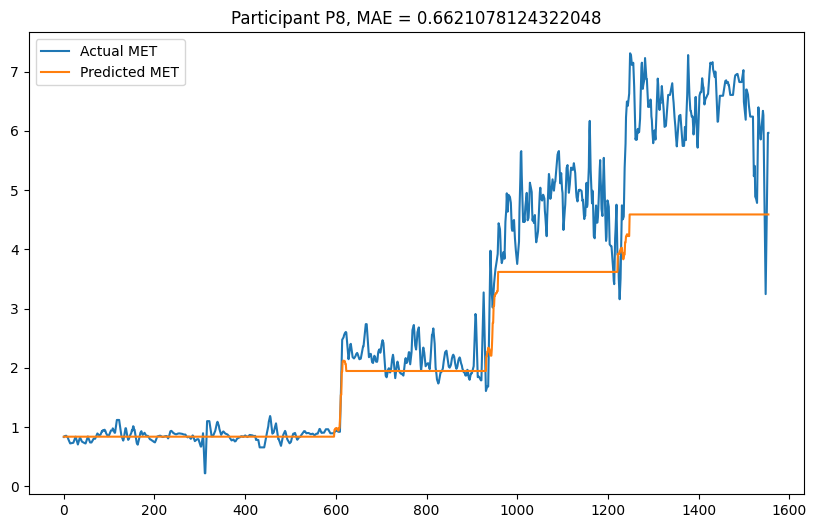

P1
Learning rate set to 0.068631
0:	learn: 2.0857686	total: 7.1ms	remaining: 7.1s
1:	learn: 1.9884553	total: 13ms	remaining: 6.46s
2:	learn: 1.9008614	total: 19.1ms	remaining: 6.36s
3:	learn: 1.8215143	total: 25.3ms	remaining: 6.29s
4:	learn: 1.7489100	total: 30.7ms	remaining: 6.12s
5:	learn: 1.6830662	total: 36.4ms	remaining: 6.03s
6:	learn: 1.6237231	total: 41.9ms	remaining: 5.95s
7:	learn: 1.5702892	total: 48.1ms	remaining: 5.97s
8:	learn: 1.5226232	total: 53.9ms	remaining: 5.94s
9:	learn: 1.4800153	total: 59.5ms	remaining: 5.89s
10:	learn: 1.4420673	total: 65.3ms	remaining: 5.87s
11:	learn: 1.4086618	total: 71.1ms	remaining: 5.85s
12:	learn: 1.3786710	total: 76.8ms	remaining: 5.83s
13:	learn: 1.3520019	total: 82.7ms	remaining: 5.82s
14:	learn: 1.3281758	total: 88.2ms	remaining: 5.79s
15:	learn: 1.3072085	total: 94.3ms	remaining: 5.8s
16:	learn: 1.2885831	total: 100ms	remaining: 5.8s
17:	learn: 1.2723113	total: 106ms	remaining: 5.8s
18:	learn: 1.2579686	total: 112ms	remaining: 5.77s

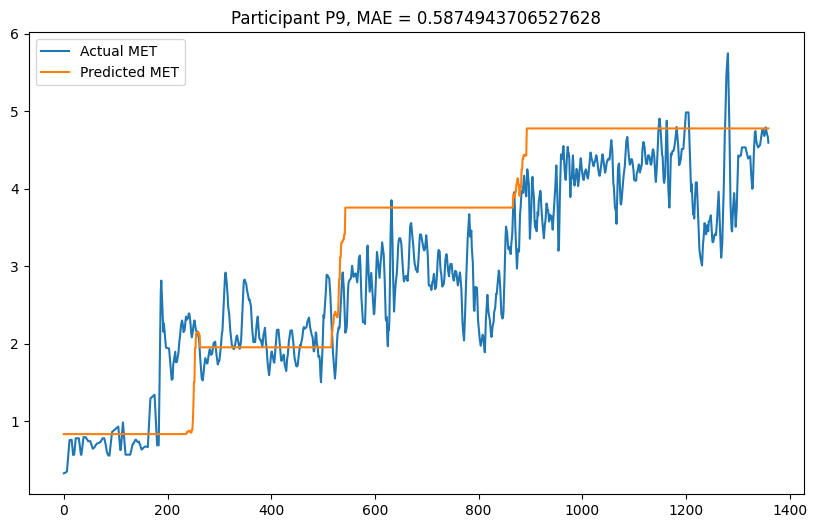

P1
Learning rate set to 0.068463
0:	learn: 2.0746891	total: 6.8ms	remaining: 6.79s
1:	learn: 1.9792170	total: 15.8ms	remaining: 7.88s
2:	learn: 1.8927814	total: 22.8ms	remaining: 7.57s
3:	learn: 1.8149634	total: 29ms	remaining: 7.21s
4:	learn: 1.7438946	total: 34.3ms	remaining: 6.82s
5:	learn: 1.6794340	total: 40.4ms	remaining: 6.69s
6:	learn: 1.6214040	total: 45.9ms	remaining: 6.51s
7:	learn: 1.5691580	total: 51ms	remaining: 6.32s
8:	learn: 1.5225758	total: 56.2ms	remaining: 6.19s
9:	learn: 1.4808383	total: 61.3ms	remaining: 6.06s
10:	learn: 1.4435987	total: 66.3ms	remaining: 5.96s
11:	learn: 1.4109541	total: 71.6ms	remaining: 5.89s
12:	learn: 1.3815690	total: 77.3ms	remaining: 5.87s
13:	learn: 1.3555399	total: 83ms	remaining: 5.85s
14:	learn: 1.3324688	total: 89.1ms	remaining: 5.85s
15:	learn: 1.3120183	total: 94.8ms	remaining: 5.83s
16:	learn: 1.2938405	total: 100ms	remaining: 5.79s
17:	learn: 1.2779731	total: 106ms	remaining: 5.78s
18:	learn: 1.2639836	total: 111ms	remaining: 5.74s

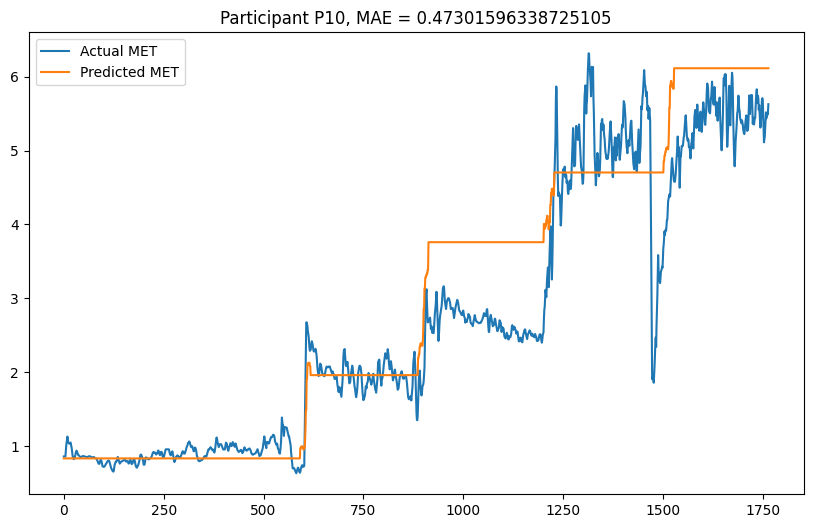

P1
Learning rate set to 0.068485
0:	learn: 1.9630371	total: 6.05ms	remaining: 6.04s
1:	learn: 1.8698260	total: 11.6ms	remaining: 5.77s
2:	learn: 1.7849793	total: 17.7ms	remaining: 5.88s
3:	learn: 1.7077555	total: 23.3ms	remaining: 5.8s
4:	learn: 1.6377923	total: 29.2ms	remaining: 5.81s
5:	learn: 1.5745038	total: 34.8ms	remaining: 5.76s
6:	learn: 1.5175712	total: 40.2ms	remaining: 5.71s
7:	learn: 1.4661302	total: 45.4ms	remaining: 5.63s
8:	learn: 1.4201665	total: 51.3ms	remaining: 5.64s
9:	learn: 1.3790517	total: 57.9ms	remaining: 5.73s
10:	learn: 1.3423300	total: 62.8ms	remaining: 5.65s
11:	learn: 1.3095150	total: 68.2ms	remaining: 5.61s
12:	learn: 1.2803485	total: 74ms	remaining: 5.62s
13:	learn: 1.2543913	total: 80.3ms	remaining: 5.66s
14:	learn: 1.2315503	total: 85.3ms	remaining: 5.6s
15:	learn: 1.2111570	total: 91ms	remaining: 5.6s
16:	learn: 1.1932167	total: 96.7ms	remaining: 5.59s
17:	learn: 1.1774493	total: 103ms	remaining: 5.61s
18:	learn: 1.1635928	total: 109ms	remaining: 5.62

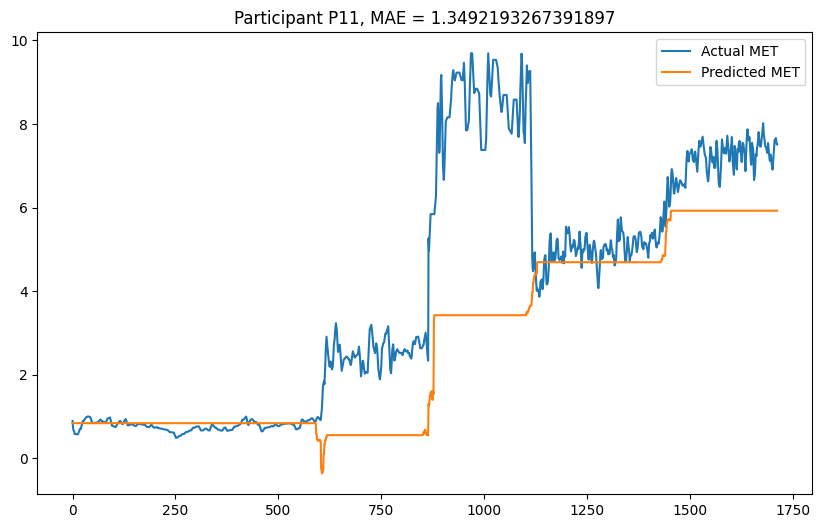

P1
Learning rate set to 0.068448
0:	learn: 2.0771519	total: 6.62ms	remaining: 6.61s
1:	learn: 1.9821737	total: 12.2ms	remaining: 6.06s
2:	learn: 1.8967805	total: 18.3ms	remaining: 6.09s
3:	learn: 1.8194808	total: 24.4ms	remaining: 6.08s
4:	learn: 1.7487442	total: 29.9ms	remaining: 5.96s
5:	learn: 1.6846507	total: 35.6ms	remaining: 5.9s
6:	learn: 1.6269405	total: 41.1ms	remaining: 5.83s
7:	learn: 1.5749985	total: 46.6ms	remaining: 5.78s
8:	learn: 1.5286807	total: 52.2ms	remaining: 5.75s
9:	learn: 1.4872591	total: 57.9ms	remaining: 5.73s
10:	learn: 1.4502683	total: 63.4ms	remaining: 5.7s
11:	learn: 1.4178269	total: 69.5ms	remaining: 5.72s
12:	learn: 1.3887393	total: 74.8ms	remaining: 5.68s
13:	learn: 1.3628882	total: 80.2ms	remaining: 5.65s
14:	learn: 1.3399815	total: 85.7ms	remaining: 5.63s
15:	learn: 1.3196913	total: 91.9ms	remaining: 5.65s
16:	learn: 1.3016356	total: 97.8ms	remaining: 5.65s
17:	learn: 1.2858804	total: 103ms	remaining: 5.64s
18:	learn: 1.2719093	total: 108ms	remaining:

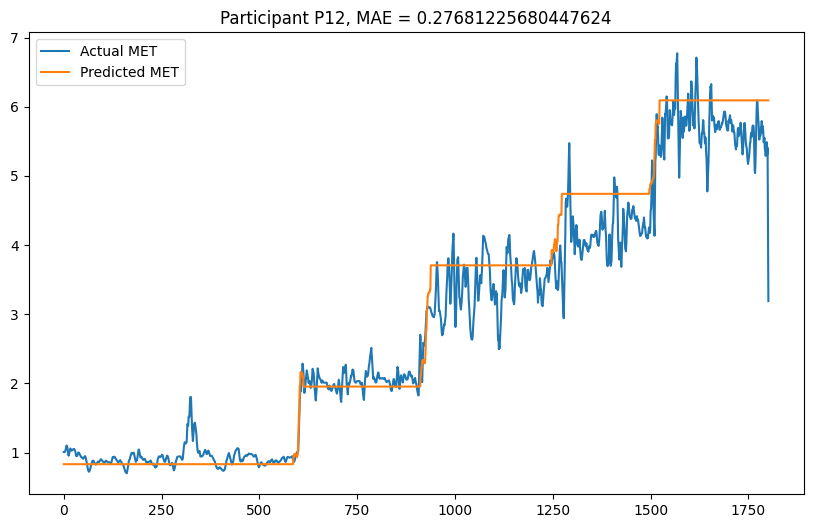

P1
Learning rate set to 0.068828
0:	learn: 2.0669171	total: 9.84ms	remaining: 9.83s
1:	learn: 1.9710844	total: 16.5ms	remaining: 8.24s
2:	learn: 1.8848780	total: 25.4ms	remaining: 8.46s
3:	learn: 1.8068423	total: 33.6ms	remaining: 8.38s
4:	learn: 1.7354659	total: 41.6ms	remaining: 8.27s
5:	learn: 1.6708140	total: 49ms	remaining: 8.12s
6:	learn: 1.6126073	total: 62.3ms	remaining: 8.84s
7:	learn: 1.5602442	total: 78.8ms	remaining: 9.77s
8:	learn: 1.5135970	total: 94.8ms	remaining: 10.4s
9:	learn: 1.4719270	total: 117ms	remaining: 11.6s
10:	learn: 1.4346563	total: 140ms	remaining: 12.6s
11:	learn: 1.4019641	total: 164ms	remaining: 13.5s
12:	learn: 1.3726763	total: 180ms	remaining: 13.7s
13:	learn: 1.3466613	total: 198ms	remaining: 14s
14:	learn: 1.3236183	total: 215ms	remaining: 14.1s
15:	learn: 1.3032300	total: 242ms	remaining: 14.9s
16:	learn: 1.2850893	total: 261ms	remaining: 15.1s
17:	learn: 1.2692646	total: 280ms	remaining: 15.3s
18:	learn: 1.2552447	total: 298ms	remaining: 15.4s
19:

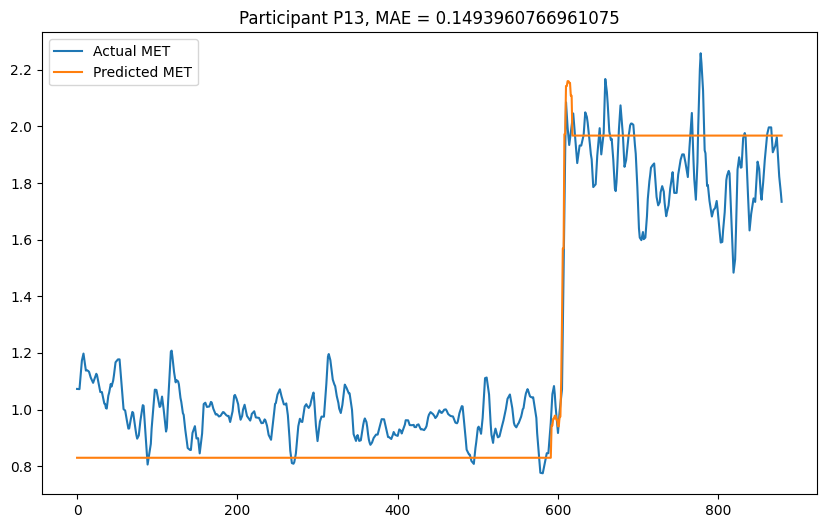

P1
Learning rate set to 0.068549
0:	learn: 2.0191683	total: 7.75ms	remaining: 7.74s
1:	learn: 1.9253260	total: 13.1ms	remaining: 6.52s
2:	learn: 1.8409107	total: 23.2ms	remaining: 7.71s
3:	learn: 1.7644293	total: 29.2ms	remaining: 7.27s
4:	learn: 1.6944422	total: 34.5ms	remaining: 6.87s
5:	learn: 1.6309642	total: 40.3ms	remaining: 6.67s
6:	learn: 1.5737622	total: 46.3ms	remaining: 6.57s
7:	learn: 1.5224345	total: 52.8ms	remaining: 6.54s
8:	learn: 1.4764681	total: 58.1ms	remaining: 6.39s
9:	learn: 1.4352858	total: 63.6ms	remaining: 6.29s
10:	learn: 1.3985339	total: 68.9ms	remaining: 6.2s
11:	learn: 1.3663092	total: 74.8ms	remaining: 6.16s
12:	learn: 1.3373996	total: 80.5ms	remaining: 6.11s
13:	learn: 1.3116944	total: 86.4ms	remaining: 6.08s
14:	learn: 1.2887965	total: 92ms	remaining: 6.04s
15:	learn: 1.2685699	total: 98.3ms	remaining: 6.04s
16:	learn: 1.2505925	total: 104ms	remaining: 6.04s
17:	learn: 1.2349105	total: 111ms	remaining: 6.04s
18:	learn: 1.2210920	total: 116ms	remaining: 6

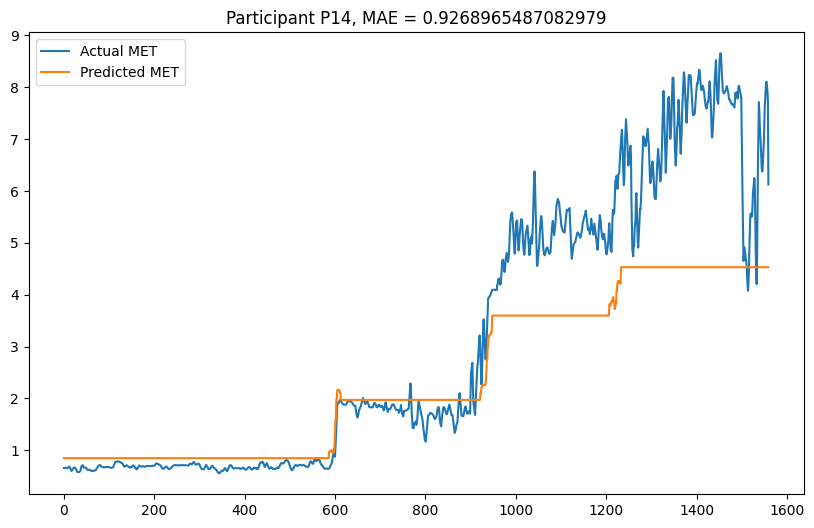

P1
Learning rate set to 0.068697
0:	learn: 2.0522832	total: 6.54ms	remaining: 6.53s
1:	learn: 1.9559217	total: 13.6ms	remaining: 6.78s
2:	learn: 1.8692001	total: 20ms	remaining: 6.63s
3:	learn: 1.7906188	total: 26.2ms	remaining: 6.53s
4:	learn: 1.7185150	total: 32.2ms	remaining: 6.4s
5:	learn: 1.6533967	total: 38ms	remaining: 6.29s
6:	learn: 1.5946127	total: 43.8ms	remaining: 6.21s
7:	learn: 1.5417862	total: 56.7ms	remaining: 7.03s
8:	learn: 1.4945591	total: 66ms	remaining: 7.27s
9:	learn: 1.4523734	total: 72.8ms	remaining: 7.21s
10:	learn: 1.4147181	total: 78.2ms	remaining: 7.03s
11:	learn: 1.3816027	total: 84.2ms	remaining: 6.93s
12:	learn: 1.3518427	total: 89.6ms	remaining: 6.8s
13:	learn: 1.3253998	total: 95.1ms	remaining: 6.7s
14:	learn: 1.3018967	total: 101ms	remaining: 6.61s
15:	learn: 1.2811227	total: 112ms	remaining: 6.87s
16:	learn: 1.2628081	total: 122ms	remaining: 7.03s
17:	learn: 1.2467690	total: 129ms	remaining: 7.04s
18:	learn: 1.2325885	total: 140ms	remaining: 7.21s
19:

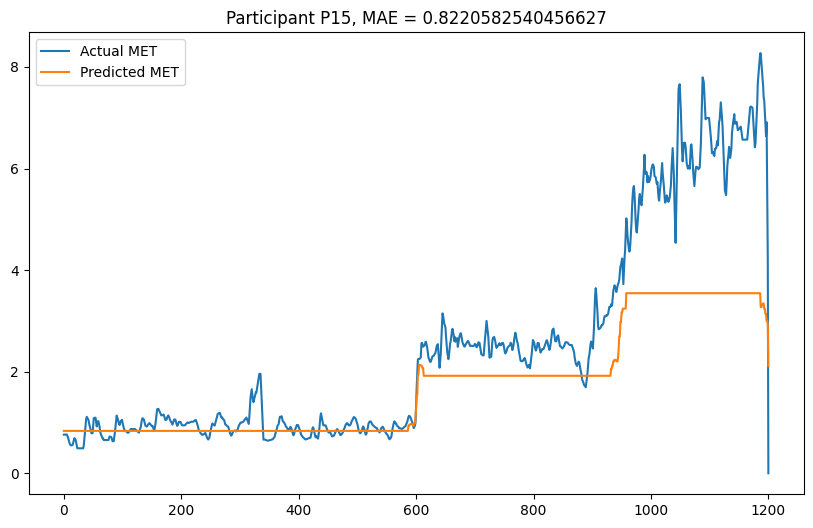

P1
Learning rate set to 0.068448
0:	learn: 1.9609809	total: 14.4ms	remaining: 14.4s
1:	learn: 1.8710121	total: 23.7ms	remaining: 11.8s
2:	learn: 1.7900472	total: 33.8ms	remaining: 11.2s
3:	learn: 1.7168752	total: 51.9ms	remaining: 12.9s
4:	learn: 1.6498534	total: 65.9ms	remaining: 13.1s
5:	learn: 1.5890363	total: 81.3ms	remaining: 13.5s
6:	learn: 1.5342600	total: 95.4ms	remaining: 13.5s
7:	learn: 1.4849595	total: 111ms	remaining: 13.7s
8:	learn: 1.4410602	total: 125ms	remaining: 13.7s
9:	learn: 1.4017330	total: 140ms	remaining: 13.9s
10:	learn: 1.3667689	total: 157ms	remaining: 14.1s
11:	learn: 1.3360648	total: 170ms	remaining: 14s
12:	learn: 1.3084446	total: 187ms	remaining: 14.2s
13:	learn: 1.2838818	total: 210ms	remaining: 14.8s
14:	learn: 1.2620973	total: 228ms	remaining: 14.9s
15:	learn: 1.2427996	total: 245ms	remaining: 15.1s
16:	learn: 1.2255721	total: 262ms	remaining: 15.1s
17:	learn: 1.2106019	total: 279ms	remaining: 15.2s
18:	learn: 1.1973668	total: 294ms	remaining: 15.2s
19:

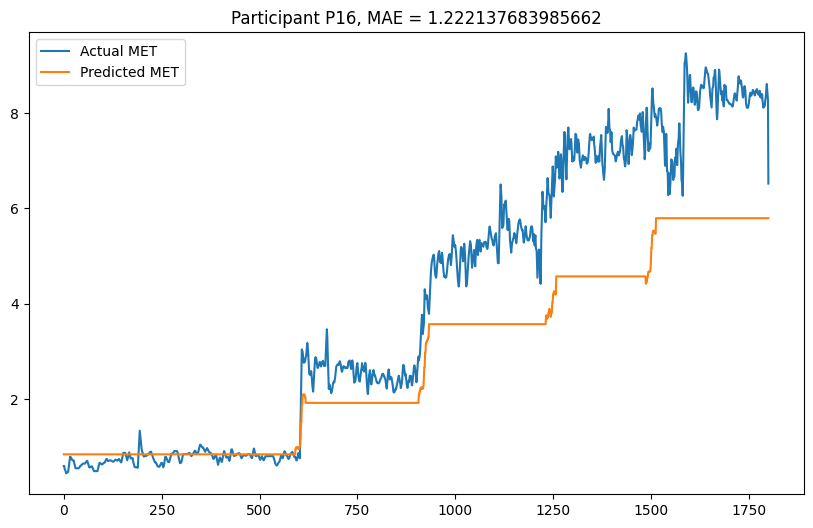

In [15]:
# print(cv)
mae_list_catboost = []
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    print(people[fold])

    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]

    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    mae = mean_absolute_error(Y_test, Y_pred)
    mae_list_catboost.append((fold + 1,mae))

    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant P{}, MAE = {}'.format(fold, mae))
    plt.legend()
    plt.show()


|  | CatBoost | XGBoost |
|----------|----------|----------|
| Parameters (before feature and tsfresh) | Row 1, Col 2 |Row 1, Col 2 |
| Parameters (after feature and tsfresh) | Row 1, Col 2 |Row 1, Col 2 |
|----------|----------|----------|
| MAE (before feature and tsfresh) | Row 2, Col 2 |Row 1, Col 2 |
| MAE (after feature and tsfresh) | Row 2, Col 2 |Row 1, Col 2 |


| XGBoost | P1 | P2 | P3 | P4 | P5 | P6 | P7 | P8 | P9 | P10 | P11 | P12 | P13 | P14 | P15 | P16 | P17 | average |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| MAE (after lag feature only) | 0.4627 | 0.9155 | 1.3807 | 0.3960 | 0.4582 | 1.3357 | 0.6074 | 0.9289 | 0.6610 | 0.5863 | 1.9578 | 1.9578 | 0.2764 | 0.1500 | 0.9286 | 0.8199 | 1.2193 | 0.7973 |
| MAE (after lag feature and tsfresh) | 0.4639 |0.9149 | 1.3810 | 0.3445 | 0.4596 | 1.3354  | 0.6068 | 0.9296 | 0.6635 | 0.5840 | 0.4706 | 1.7744 | 0.2788 | 0.1509 | 0.9290 | 0.8198 | 1.2183 | 0.7867 |


| CatBoost | P1 | P2 | P3 | P4 | P5 | P6 | P7 | P8 | P9 | P10 | P11 | P12 | P13 | P14 | P15 | P16 | P17 | average |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| MAE (after lag feature only) | 0.4611 | 0.9169 | 1.3928 | 0.3963 | 0.4574 | 1.3281 | 0.6046 | 0.9224 | 0.6621 | 0.5875 | 0.4730 | 1.3199 | 0.2768 | 0.1494 | 0.9269 | 0.8235 | 1.2221 | 0.7600 |
| MAE (after feature and tsfresh) | 0.4611 | 0.9169 | 1.3879 | 0.3963 | 0.4574 | 1.3293  | 0.6046 | 0.9224 | 0.6621 | 0.5875 | 0.4730 | 1.3492 | 0.2768 | 0.1494 | 0.9269 | 0.8221 | 1.2221 | 0.7615 |


In [16]:
mae_list_catboost

[(1, 0.46107172861562135),
 (2, 0.9168886141023008),
 (3, 1.3878981792391862),
 (4, 0.39631289231808725),
 (5, 0.4574132209900711),
 (6, 1.3292561703967223),
 (7, 0.6045980419569368),
 (8, 0.9223968650024097),
 (9, 0.6621078124322048),
 (10, 0.5874943706527628),
 (11, 0.47301596338725105),
 (12, 1.3492193267391897),
 (13, 0.27681225680447624),
 (14, 0.1493960766961075),
 (15, 0.9268965487082979),
 (16, 0.8220582540456627),
 (17, 1.222137683985662)]

In [17]:
mae_list_xgboost

[(1, 0.46387717466796086),
 (2, 0.9149215108329913),
 (3, 1.3809702341075256),
 (4, 0.394466174642943),
 (5, 0.4595980250537629),
 (6, 1.3353880215004046),
 (7, 0.6067993375387561),
 (8, 0.9295808387783178),
 (9, 0.6634773733607627),
 (10, 0.583980574637405),
 (11, 0.4705833151954439),
 (12, 1.774357779181063),
 (13, 0.27878833480953963),
 (14, 0.1508823210766168),
 (15, 0.928956506748254),
 (16, 0.8197710474406845),
 (17, 1.2183006433900332)]

In [20]:
averages = tuple(sum(col) / len(mae_list_xgboost) for col in zip(*mae_list_xgboost))
print("Averages:", averages)


Averages: (9.0, 0.7867470125272038)


In [22]:
averages = tuple(sum(col) / len(mae_list_catboost) for col in zip(*mae_list_catboost))
print("Averages:", averages)

Averages: (9.0, 0.7614690591807618)
